In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import nltk
nltk.download('wordnet')
import pandas as pd
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,f1_score
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/data.txt',sep="\t",header=None)
data.columns = ["label","text"]
data.head()

,label,text
0,1,neil burger here succeeded in making the myste...
1,0,it is a visual rorschach test and i must have ...
2,0,the only way to tolerate this insipid brutally...
3,0,scores no points for originality wit or intell...
4,0,it would take a complete moron to foul up a sc...


In [4]:
X_train = pd.read_csv("/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/X_train.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/X_test.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/y_train.csv")
y_test =  pd.read_csv('/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/y_test.csv')

In [5]:
import numpy as np
X_train = X_train["text"]
X_test = X_test["text"]
y_train = y_train["label"]
y_test = y_test["label"]

In [9]:
X_train.shape

(400,)

In [6]:
# Embedding'leri yükleme
X_train_embeddings = np.load(f"/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/embedding_orj_train.npy")
X_test_embeddings = np.load(f"/content/drive/MyDrive/Yüksek Lisans 2. Dönem/Kolektif Öğrenme/Proje 4/Proje 4 2. Çalışma/embedding_orj_test.npy")

## Base Model

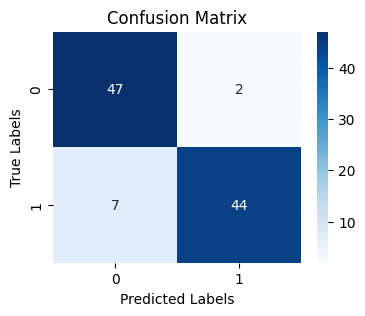

Accuracy: 0.91
F1 Score: 0.9098648783905514
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        49
           1       0.96      0.86      0.91        51

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,f1_score
import seaborn as sns
import matplotlib.pyplot as plt
#Base model
model = RandomForestClassifier()
model.fit(X_train_embeddings, y_train)
y_pred = model.predict(X_test_embeddings)

cm = confusion_matrix(y_test, y_pred)
# Heatmap çizimi
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

## Radom Deletion

In [13]:
#Train verisini 2 katına çıkarmak

In [5]:
import random

# Random Deletion Fonksiyonu
def random_deletion(words, p=0.2):
    """
    Random Deletion: Bir cümledeki kelimeleri belirli bir olasılıkla siler.
    :param words: Cümleyi oluşturan kelimeler listesi.
    :param p: Silme olasılığı (0 ile 1 arasında).
    :return: Silme işlemi yapılmış yeni kelime listesi.
    """
    if len(words) == 1:
        return words  # Tek kelime varsa hiçbir şey silme

    new_words = []
    for word in words:
        if random.uniform(0, 1) > p:  # Kelimeyi silme olasılığı
            new_words.append(word)

    # Eğer tüm kelimeler silinmişse en az bir kelime bırak
    if len(new_words) == 0:
        new_words.append(random.choice(words))

    return new_words

# Random Deletion ile Augmentation
def augment_data_random_deletion_series(X_text, num_aug=3, p=0.2):
    """
    Random deletion yöntemiyle pandas.Series verisini genişletir.
    :param X_text: Orijinal test verisi (pandas.Series).
    :param num_aug: Her cümle için kaç augment yapılacağı.
    :param p: Silme olasılığı.
    :return: Augment edilmiş cümlelerin pandas.Series olarak döndürülmesi.
    """
    augmented_sentences = []
    for sentence in X_text:
        words = sentence.split()
        augmented = [random_deletion(words, p=p) for _ in range(num_aug)]
        augmented_sentences.extend([" ".join(sent) for sent in augmented])

    return augmented_sentences

In [24]:
random_deletion_train_2 = augment_data_random_deletion_series(X_train, num_aug=2, p=0.3)

In [26]:
random_deletion_augmented_train_2 = pd.DataFrame({'text': random_deletion_train_2, 'label': y_train.repeat(2)})
X_deletion_embeddings = SentenceTransformer("intfloat/multilingual-e5-large-instruct").encode(random_deletion_augmented_train_2['text'].tolist(),batch_size=32,show_progress_bar=True)
y__random_deletion_augmented = random_deletion_augmented_train_2['label']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/140k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

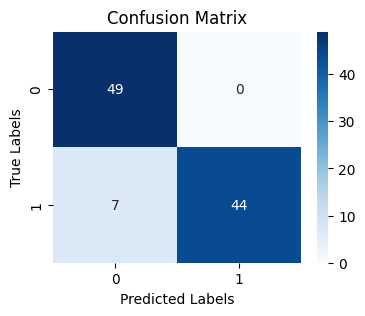

Accuracy: 0.93
F1 Score: 0.9297543859649123
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        49
           1       1.00      0.86      0.93        51

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100



In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,f1_score
import seaborn as sns
import matplotlib.pyplot as plt
#Base model
model = RandomForestClassifier()
model.fit(X_deletion_embeddings, y__random_deletion_augmented)
y_pred = model.predict(X_test_embeddings)

cm = confusion_matrix(y_test, y_pred)
# Heatmap çizimi
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

In [31]:
#Train verisini 3 katına çıkarmak

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

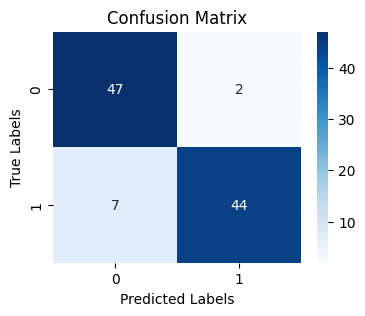

Accuracy: 0.91
F1 Score: 0.9098648783905514
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        49
           1       0.96      0.86      0.91        51

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



In [33]:
random_deletion_train_3 = augment_data_random_deletion_series(X_train, num_aug=3, p=0.3)
random_deletion_augmented_train_3 = pd.DataFrame({'text': random_deletion_train_3, 'label': y_train.repeat(3)})
X_deletion_embeddings = SentenceTransformer("intfloat/multilingual-e5-large-instruct").encode(random_deletion_augmented_train_3['text'].tolist(),batch_size=32,show_progress_bar=True)
y__random_deletion_augmented = random_deletion_augmented_train_3['label']

model = RandomForestClassifier()
model.fit(X_deletion_embeddings, y__random_deletion_augmented)
y_pred = model.predict(X_test_embeddings)

cm = confusion_matrix(y_test, y_pred)
# Heatmap çizimi
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

In [7]:
#Train verisini 5 katına çıkarmak
random_deletion_train_5 = augment_data_random_deletion_series(X_train, num_aug=5, p=0.3)
random_deletion_augmented_train_5 = pd.DataFrame({'text': random_deletion_train_5, 'label': y_train.repeat(5)})
X_deletion_embeddings = SentenceTransformer("intfloat/multilingual-e5-large-instruct").encode(random_deletion_augmented_train_5['text'].tolist(),batch_size=32,show_progress_bar=True)
y__random_deletion_augmented = random_deletion_augmented_train_5['label']



Batches:   0%|          | 0/63 [00:00<?, ?it/s]

NameError: name 'RandomForestClassifier' is not defined

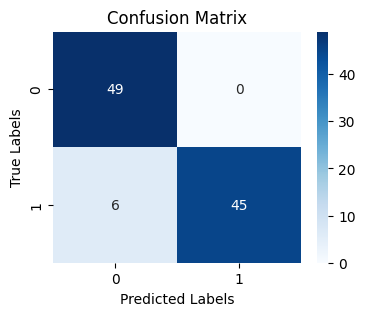

Accuracy: 0.94
F1 Score: 0.9398557692307692
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        49
           1       1.00      0.88      0.94        51

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100



In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
model = RandomForestClassifier()
model.fit(X_deletion_embeddings, y__random_deletion_augmented)
y_pred = model.predict(X_test_embeddings)

cm = confusion_matrix(y_test, y_pred)
# Heatmap çizimi
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

## Synonym Replacement

In [9]:
#Train verisini 2 katına çıkarmak

In [29]:
import random
from nltk.corpus import wordnet
from scipy.stats import mode

# get_synonyms fonksiyonu
def get_synonyms(word):
    """WordNet kullanarak eş anlamlı kelimeleri döndürür."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

# Synonym Replacement Fonksiyonu
def synonym_replacement(words, n):
    """Kelime listesinde rastgele kelimeleri eş anlamlılarıyla değiştirir."""
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

In [30]:
def augment_data(X_train, technique, num_aug=3):
    """Seçilen augmentasyon tekniğiyle test verisini genişletir."""
    augmented_sentences = []
    for sentence in X_train:
        words = sentence.split()
        num_words = len(words)
        n = max(1, int(0.1 * num_words))  # Her augmentasyon için kullanılan kelime sayısı
        if technique == "synonym_replacement":
            augmented = [synonym_replacement(words, n) for _ in range(num_aug)]
        # Diğer teknikler buraya eklenebilir.
        augmented_sentences.extend([" ".join(sent) for sent in augmented])
    return augmented_sentences

In [31]:
def generate_embeddings(sentences, embedding_model_name="intfloat/multilingual-e5-large-instruct"):
    """Verilen cümleler için embedding oluşturur."""
    embedding_model = SentenceTransformer(embedding_model_name)
    embeddings = embedding_model.encode(sentences, batch_size=32, show_progress_bar=True)
    return embeddings

In [28]:
len(X_train)

400

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

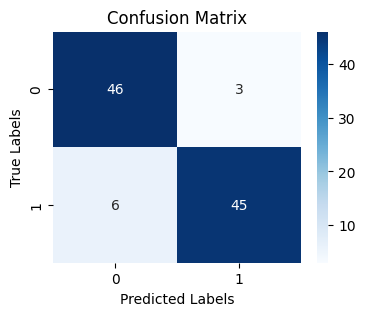

Accuracy: 0.91
F1 Score: 0.9099729972997299
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        49
           1       0.94      0.88      0.91        51

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



In [32]:
# Augmentation
augmented_sentences_2 = augment_data(X_train, technique="synonym_replacement", num_aug=2)
synonym_augmented_train_2 = pd.DataFrame({'text': augmented_sentences_2, 'label': y_train.repeat(2)})

# Embedding
X_train_synonym_augmented_embeddings = generate_embeddings(augmented_sentences_2)

model.fit(X_train_synonym_augmented_embeddings, synonym_augmented_train_2["label"])
y_pred = model.predict(X_test_embeddings)

cm = confusion_matrix(y_test, y_pred)
# Heatmap çizimi
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

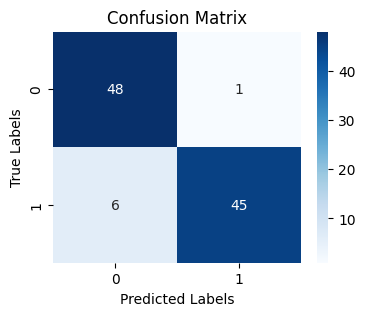

Accuracy: 0.93
F1 Score: 0.9298949054148734
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        49
           1       0.98      0.88      0.93        51

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [33]:
# Augmentation
augmented_sentences_3 = augment_data(X_train, technique="synonym_replacement", num_aug=3)
synonym_augmented_train_3 = pd.DataFrame({'text': augmented_sentences_3, 'label': y_train.repeat(3)})

# Embedding
X_train_synonym_augmented_embeddings = generate_embeddings(augmented_sentences_3)

model.fit(X_train_synonym_augmented_embeddings, synonym_augmented_train_3["label"])
y_pred = model.predict(X_test_embeddings)

cm = confusion_matrix(y_test, y_pred)
# Heatmap çizimi
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

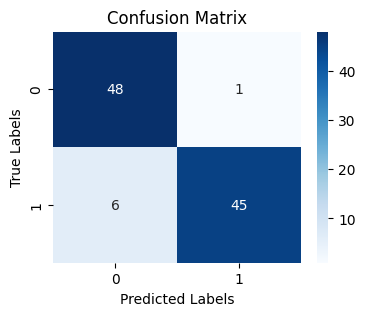

Accuracy: 0.93
F1 Score: 0.9298949054148734
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        49
           1       0.98      0.88      0.93        51

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [35]:
# Augmentation
augmented_sentences_5 = augment_data(X_train, technique="synonym_replacement", num_aug=5)
synonym_augmented_train_5 = pd.DataFrame({'text': augmented_sentences_5, 'label': y_train.repeat(5)})

# Embedding
X_train_synonym_augmented_embeddings = generate_embeddings(augmented_sentences_5)

model.fit(X_train_synonym_augmented_embeddings, synonym_augmented_train_5["label"])
y_pred = model.predict(X_test_embeddings)

cm = confusion_matrix(y_test, y_pred)
# Heatmap çizimi
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

## Back Translation

In [1]:
!pip install googletrans==4.0.0-rc1

In [12]:
#Train verisini 2 katına çıkarmak

In [8]:
from googletrans import Translator

# Back Translation için diller
languages = ['de', 'fr']  # Almanca, Fransızca, İspanyolca
translator = Translator()

def back_translate(text, lang):
    """
    Metni verilen dile çevirip tekrar İngilizceye çevirir.
    """
    try:
        # İngilizce -> Hedef Dil
        translated = translator.translate(text, src='en', dest=lang).text
        # Hedef Dil -> İngilizce
        back_translated = translator.translate(translated, src=lang, dest='en').text
        return back_translated
    except Exception as e:
        print(f"Error in translation: {e}")
        return text  # Çeviri başarısızsa orijinal metni döndür

def augment_data(data, languages):
    """
    Back translation ile sadece üretilmiş veriyi döndürür.
    """
    augmented_data = []
    for text in data:
        for lang in languages:
            augmented_text = back_translate(text, lang)
            augmented_data.append(augmented_text)
    return augmented_data


# Augmented veri oluşturma
tranlation_augmented_data_2 = augment_data(X_train, languages)


In [9]:
backtranslation_augmented_train_2 = pd.DataFrame({'text': tranlation_augmented_data_2, 'label': y_train.repeat(2)})
X_back_translation_embeddings = SentenceTransformer("intfloat/multilingual-e5-large-instruct").encode(backtranslation_augmented_train_2['text'].tolist(),batch_size=32,show_progress_bar=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

NameError: name 'model' is not defined

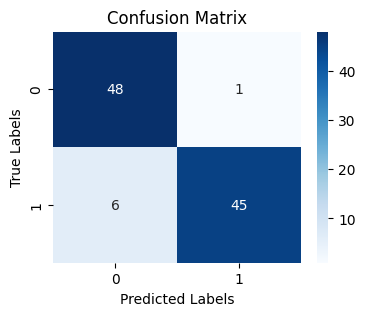

Accuracy: 0.93
F1 Score: 0.9298949054148734
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        49
           1       0.98      0.88      0.93        51

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [11]:
model.fit(X_back_translation_embeddings, backtranslation_augmented_train_2["label"])
y_pred = model.predict(X_test_embeddings)

cm = confusion_matrix(y_test, y_pred)
# Heatmap çizimi
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

In [13]:
#Train verisini 3 katına çıkarmak

Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'NoneType' object is not iterable
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exc

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

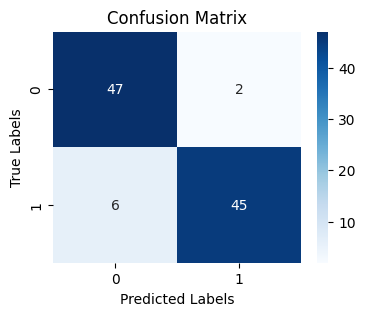

Accuracy: 0.92
F1 Score: 0.9199359743897559
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        49
           1       0.96      0.88      0.92        51

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



In [14]:
# Augmented veri oluşturma
languages = ['de', 'fr', 'es']
tranlation_augmented_data_3 = augment_data(X_train, languages)

backtranslation_augmented_train_3 = pd.DataFrame({'text': tranlation_augmented_data_3, 'label': y_train.repeat(3)})
X_back_translation_embeddings = SentenceTransformer("intfloat/multilingual-e5-large-instruct").encode(backtranslation_augmented_train_3['text'].tolist(),batch_size=32,show_progress_bar=True)

model.fit(X_back_translation_embeddings, backtranslation_augmented_train_3["label"])
y_pred = model.predict(X_test_embeddings)

cm = confusion_matrix(y_test, y_pred)
# Heatmap çizimi
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

In [ ]:
#Train verisini 5 katına çıkartma

Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'NoneType' object is not iterable
Error in translation: 'Translator' object has no attribute 'raise_Exception'
Error in translation: 'Translator' object has no attribute 'raise_Exception'

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

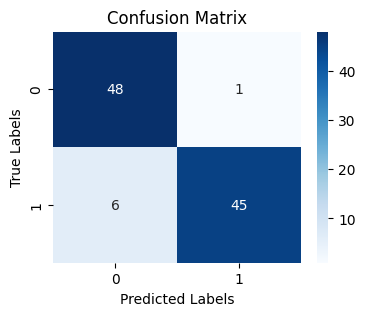

Accuracy: 0.93
F1 Score: 0.9298949054148734
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        49
           1       0.98      0.88      0.93        51

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [16]:
# Augmented veri oluşturma
languages = ['de', 'fr', 'es', 'it', 'pt']
tranlation_augmented_data_5 = augment_data(X_train, languages)

backtranslation_augmented_train_5 = pd.DataFrame({'text': tranlation_augmented_data_5, 'label': y_train.repeat(5)})
X_back_translation_embeddings = SentenceTransformer("intfloat/multilingual-e5-large-instruct").encode(backtranslation_augmented_train_5['text'].tolist(),batch_size=32,show_progress_bar=True)

model.fit(X_back_translation_embeddings, backtranslation_augmented_train_5["label"])
y_pred = model.predict(X_test_embeddings)

cm = confusion_matrix(y_test, y_pred)
# Heatmap çizimi
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))